In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
cols = ['ID(original)', 'ID' , 'Q' , 'A']
data = pd.read_csv('COQB-19_crowdsourced_06202020.csv', sep=',', names=cols, header=None, encoding='latin-1',skiprows=1)
data = data.dropna()
Questions = data['Q']
ID= data['ID'].tolist()
corpus = Questions.tolist()
Answers =data['A'].tolist()

In [3]:
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words= word_tokenize(sentence)
    lematized_tokens = [lemmatizer.lemmatize(w) for w in token_words]
    return "  ".join(lematized_tokens)

In [4]:
stemmed_corpus = []
SC = []
for i in range(len(corpus)):
  stemmed_corpus.append((i,stemSentence(corpus[i].lower())))
  SC.append(stemSentence(corpus[i].lower()))

In [5]:
vectorizer = TfidfVectorizer()

In [8]:
X = vectorizer.fit_transform(SC)

In [9]:
mat_x = X.toarray()

In [10]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=615, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

In [11]:
def answer_question(question, corpus_X):
  """  returns (top_idx,  top_idx_score, all_scores)
  top_idx: index of most similar question
  top_idx_score:  score of most similar question.
  all_scores: scores of all candidates.
  """
  lematized_question = stemSentence(question)
  question_x = vectorizer.transform([lematized_question])
  question_x = svd_model.transform(question_x)
  sim_scores = cosine_similarity(question_x,  corpus_X).ravel()
  top_idx = np.argmax(sim_scores)
  return top_idx, sim_scores[top_idx], sim_scores

In [12]:
x2 = 'who are you?'

In [13]:
answer_idx, answer_score,_ = answer_question(x2.lower(), lsa)
print('Similarity score = ', answer_score)
print('Most similiar question: ', corpus[stemmed_corpus[answer_idx][0]])
print('suggested answer: ', Answers[stemmed_corpus[answer_idx][0]])

Similarity score =  0.0
Most similiar question:  is it true that 5G causes the Corona virus?
suggested answer:  No. This is one of the myths that was busted by the WHO. Biological viruses cannot travel on radio waves/mobile networks. Also, COVID-19 is spreading to many countries that do not have 5G mobile networks.


In [14]:
A = svd_model.fit(X)
#print(A.explained_variance_ratio_)
print(A.explained_variance_ratio_.sum())

0.966516206762055


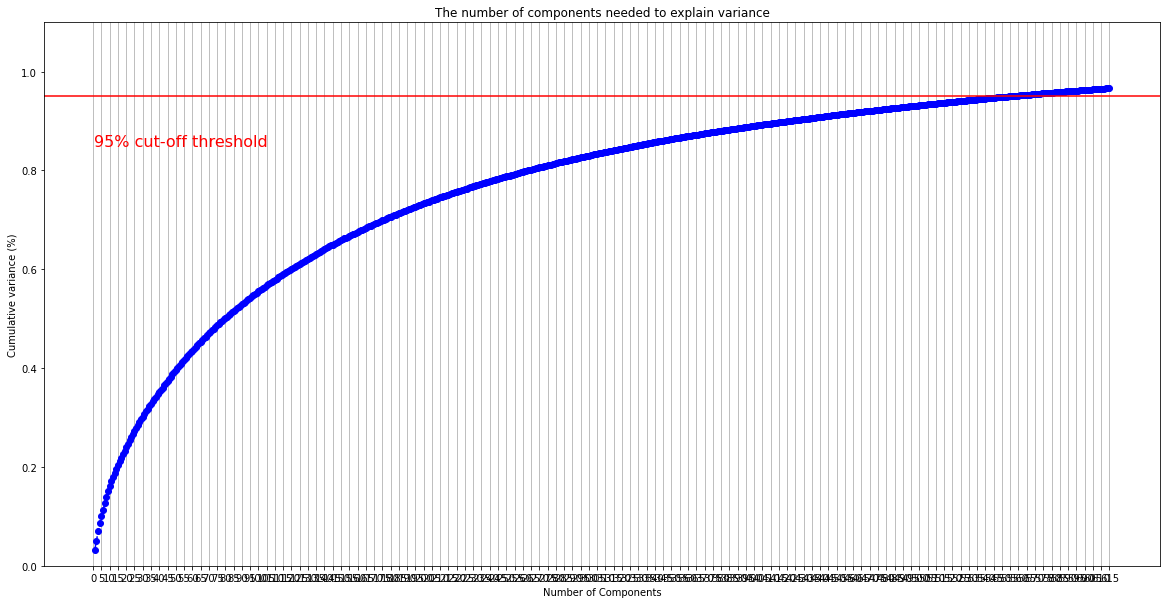

In [15]:
plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
xi = np.arange(1, 616, step=1)
y = np.cumsum(A.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 616, step=5))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [16]:
def compute_precision_recall_at_threshold(corpus, ids, corpus_X, threshold):
  precision_list = []
  recall_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    preds = scores >= threshold
    labels = np.array([a_id==ids[i] for a_id in ids])
    precision_list.append(precision_score(labels, preds))
    recall_list.append(recall_score(labels, preds))
  return np.mean(precision_list),  np.mean(recall_list)

In [17]:
probability_thresholds = np.linspace(0,1, num=50)
prec_list =[]
rec_list =[]
for threshold in probability_thresholds:
  cur_prec, cur_rec = compute_precision_recall_at_threshold(corpus, ID,  lsa, threshold)
  prec_list.append(cur_prec)
  rec_list.append(cur_rec)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

Text(0, 0.5, 'precision')

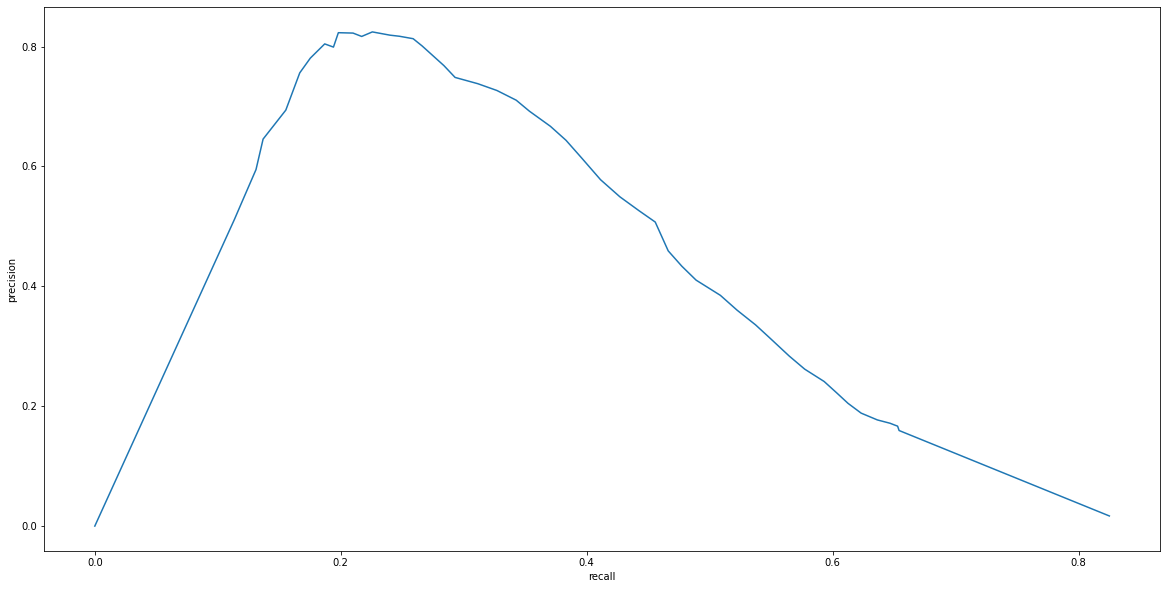

In [18]:
plt.plot(rec_list,  prec_list)
plt.xlabel('recall')
plt.ylabel('precision')

In [19]:
def compute_prec_recall_at_k(corpus, ids, corpus_X, k=5):
  prec_at_k_list = []
  recall_at_k_list = []
  for i,test_doc in enumerate(corpus):
    if i%20 != 0:
    # this is done only to speed calculations a bit. we compute metrics based
    # on 5% of data.
      continue
    _,_,  scores = answer_question(test_doc, corpus_X)
    top_k_idx = np.argsort(scores)[::-1][:k]
    top_k_labels = [ids[idx] for idx in top_k_idx]
    num_true_labels = np.sum([a_id==ids[i] for a_id in ids])
    num_true_in_top_k = np.sum([a_id==ids[i] for a_id in top_k_labels])
    cur_prec_at_k = num_true_in_top_k/k
    cur_recall_at_k = num_true_in_top_k / num_true_labels
    recall_at_k_list.append(cur_recall_at_k)
    prec_at_k_list.append(cur_prec_at_k)
  return np.mean(prec_at_k_list), np.mean(recall_at_k_list)

In [20]:
print("Prec, Recall at 1 : ",  compute_prec_recall_at_k(corpus, ID, lsa, 1))

Prec, Recall at 1 :  (0.8389830508474576, 0.13282580432913552)


In [23]:
print("Prec, Recall at 5 : ",  compute_prec_recall_at_k(corpus, ID, lsa, 5))

Prec, Recall at 5 :  (0.5949152542372882, 0.2702519980473176)


In [22]:
print("Prec,Recall at 10 : ",  compute_prec_recall_at_k(corpus, ID, lsa, 10))

Prec,Recall at 10 :  (0.4847457627118644, 0.35926850777750213)
